In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from IPython.display import HTML

In [2]:
df = pd.read_csv('input/activities.csv', parse_dates=[0])

In [3]:
print(df.shape)
df.head()

(428, 5)


,Date,Steps,Distance (m),Elevation (m),Active calories
0,2017-08-15,153,120.360,0,4
1,2017-08-14,10698,9666.177,0,372
2,2017-08-13,10871,8683.468,0,311
3,2017-08-12,20101,22102.342,0,1358
4,2017-08-11,7157,5614.810,0,196


# Daily steps calendar heatmap

In [4]:
df_steps = pd.concat([df.Date.dt.strftime("%s"), df.Steps], axis=1)

In [5]:
dic_steps = dict()
for k,x in df_steps.iterrows():
    dic_steps[x['Date']] = x['Steps']

In [12]:
html_code ="""
<script type="text/javascript" src="//d3js.org/d3.v3.min.js"></script>
<script type="text/javascript" src="//cdn.jsdelivr.net/cal-heatmap/3.3.10/cal-heatmap.min.js"></script>
<link rel="stylesheet" href="//cdn.jsdelivr.net/cal-heatmap/3.3.10/cal-heatmap.css" />
<div id="cal-heatmap"></div>
<button id="example-c-PreviousDomain-selector" style="margin-bottom: 10px;" class="btn"><i class="icon icon-chevron-left"></i></button>
<button id="example-c-NextDomain-selector" style="margin-bottom: 10px;" class="btn"><i class="icon icon-chevron-right"></i></button>
<script type="text/javascript">
    var cal = new CalHeatMap();
    cal.init({
        start: new Date(2016, 3, 1, 1), // January, 1st 2000
        range: 12,
        domain: "month",
        subDomain: "day",
        nextSelector: "#example-c-NextDomain-selector",
        previousSelector: "#example-c-PreviousDomain-selector",
        data: %s,
        legend: [3000, 7000, 10000, 15000, 20000],
        legendColors: ["#ecf5e2", "#232181"]
    });
</script>""" % dic_steps

In [13]:
HTML(html_code)

# Steps per day scatter plot

In [14]:
list_steps = []
for k,x in df.iterrows():
    list_steps.append({'x': x['Date'].strftime("%Y-%m-%d"), 'y': x['Steps']})

## Mean steps

In [15]:
x=df['Date'].dt.strftime("%s").astype('int').values
y=df['Steps'].values
num_samples = 100
p, cov = np.polyfit(x, y, 3, cov=True)
z = np.poly1d(p)

xi = np.linspace(np.min(x), np.max(x), num_samples)
yi = z(xi)

In [16]:
list_mean_steps = []
list_upper_steps = []
list_lower_steps = []
for i in range(num_samples):
    list_mean_steps.append({'x': pd.to_datetime(xi, unit='s', errors='ignore')[i].strftime("%Y-%m-%d"), 'y': np.round(yi[i])})
    list_upper_steps.append({'x': pd.to_datetime(xi, unit='s', errors='ignore')[i].strftime("%Y-%m-%d"), 'y': np.round(yi[i]+np.percentile(df['Steps'],2.5))})
    list_lower_steps.append({'x': pd.to_datetime(xi, unit='s', errors='ignore')[i].strftime("%Y-%m-%d"), 'y': np.round(yi[i]-np.percentile(df['Steps'],2.5))})

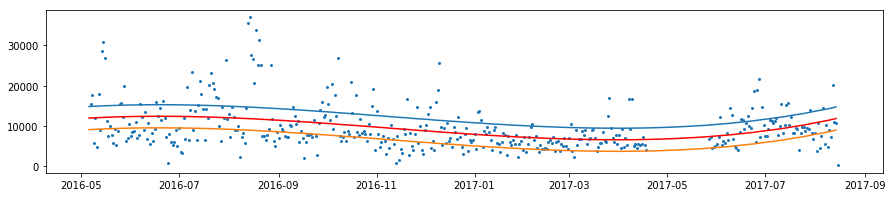

In [17]:
plt.figure(figsize=(15,3))
plt.scatter(x=[pd.to_datetime(x['x'], format='%Y-%m-%d') for x in list_steps], y=[x['y'] for x in list_steps], s=4)
plt.plot([pd.to_datetime(x['x'], format='%Y-%m-%d') for x in list_mean_steps], [x['y'] for x in list_mean_steps], '-r')
plt.plot([pd.to_datetime(x['x'], format='%Y-%m-%d') for x in list_upper_steps], [x['y'] for x in list_upper_steps], '-')
plt.plot([pd.to_datetime(x['x'], format='%Y-%m-%d') for x in list_lower_steps], [x['y'] for x in list_lower_steps], '-')
plt.show()

# Average steps per day and month

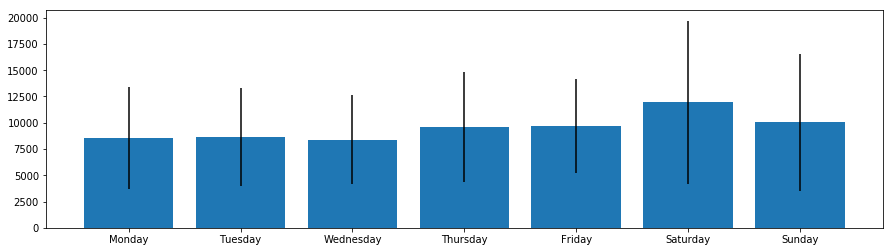

In [24]:
plt.figure(figsize=(15,4))
weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.bar(df.groupby(df['Date'].dt.dayofweek).agg({'Steps':np.mean}).round(2).index, df.groupby(df['Date'].dt.dayofweek).agg({'Steps':np.mean}).round(2).values, yerr=df.groupby(df['Date'].dt.dayofweek).agg({'Steps':np.std}).round(2).values)
plt.xticks(df.groupby(df['Date'].dt.dayofweek).agg({'Steps':np.mean}).round(2).index, weekday)
plt.show()

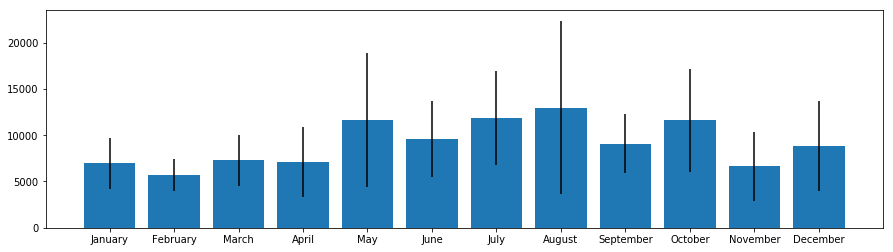

In [29]:
plt.figure(figsize=(15,4))
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.bar(df.groupby(df['Date'].dt.month).agg({'Steps':np.mean}).round(2).index, df.groupby(df['Date'].dt.month).agg({'Steps':np.mean}).round(2).values, yerr=df.groupby(df['Date'].dt.month).agg({'Steps':np.std}).round(2).values)
plt.xticks(df.groupby(df['Date'].dt.month).agg({'Steps':np.mean}).round(2).index, months)
plt.show()

# Export to csv

In [30]:
with open('output/withings_steps.json', 'w') as outfile:
    json.dump({'steps_mean_low': list_lower_steps,
               'steps_mean_high': list_upper_steps,
               'steps_mean': list_mean_steps,
               'steps_points': list_steps,
               'steps_heatmap': dic_steps,
               'steps_month': { 'index': months, 'values': [x[0] for x in df.groupby(df['Date'].dt.month).agg({'Steps':np.mean}).round(1).values ] },
               'steps_weekday': { 'index': weekday, 'values': [x[0] for x in df.groupby(df['Date'].dt.dayofweek).agg({'Steps':np.mean}).round(1).values] }
              }, outfile, indent=1)